In [1]:
import sys 
import os 
sys.path.insert(1, '..')
sys.path.insert(2, '../modules/')

from glob import glob
import re
import pickle
import numpy as np
import os
import pandas as pd
# from ruffus.task import fill_queue_with_job_parameters

from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import sys

import query_the_data


import dataconfig
import convert_datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import clean_img_data_02
import sxi_module
import helio_reg_exp_module

import coordinate_conversion_module

import convex_fits_and_filtering_module

import associate_HARP_to_flare_region_module

import associate_candidates_to_flare_meta_module

import check_data_qual_module_02

import LASSO_metrics_module

from skimage.transform import rotate
import sunpy.map
import matplotlib.patches as patches

from modules import ALEXIS_02_plotting_module_movie as plot_mod

from modules import ALEXIS_02_define_goes_class_module

loaded libraries sxi module: 0:00:01.375426
loaded libraries clean_img_02 module: 0:00:00.450046
loaded libraries sxi module: 0:00:00.000034


In [2]:
infiles = glob(f'{dataconfig.DATA_DIR_FLARE_CANDIDATES}/*.working/defined_flares_w_harp_meta_and_goes_flare_class.pickle')
len(infiles)

1

In [3]:
infile = infiles[0]

these_flares = pd.DataFrame(pickle.load(open(infile, 'rb')))

working_dir = these_flares.iloc[0].working_dir

good_quality_data_df = pickle.load(open(f'{working_dir}/initialize_with_these_files_df.pickle', 'rb'))

mask_properties = these_flares.iloc[0]

this_wl, this_inst, this_tel = mask_properties.img_wavelength, mask_properties.img_instrument, mask_properties.img_telescope

these_images = good_quality_data_df[(good_quality_data_df.wavelength == this_wl) & (good_quality_data_df.telescope == this_tel) & (good_quality_data_df.instrument == this_inst) & (good_quality_data_df.QUALITY == 0)]

these_images['catalog_file'] = [infile for _ in these_images.file_path]

# load and save xrs data

xrs_b_data = ALEXIS_02_define_goes_class_module.find_xrs_data(these_flares)

xrs_real_data_file_path = os.path.join(working_dir, 'real_xrs_data.pickle')

pickle.dump(xrs_b_data, open(xrs_real_data_file_path, 'wb'))

these_images['real_xrs_data_path'] = [xrs_real_data_file_path for _ in these_images.file_path]



In [4]:
def plot_img_zoom_ins_for_movie(axis, this_img_df, catalog_df, tracking_number, cluster_label):
    
    df = catalog_df.iloc[0]
    
    init_file = f'{df.working_dir}/initialize_with_these_files_df.pickle'

    init_files = pickle.load(open(init_file, 'rb'))

    masked_img = init_files[(init_files.wavelength == df.img_wavelength ) & (init_files.telescope == df.img_telescope ) ]

    instrument = df.img_instrument
    
    all_imgs_max = masked_img.img_data_max.max()

    if instrument == 'AIA':

        img_dict, data,header = clean_img_data_02.clean_aia_data(this_img_df.to_dict('records')[0])
        
        data_map = sunpy.map.Map(data, header)
        
        r_sun = header['R_SUN']

    if instrument == 'SXI':

        img_dict, raw_data, header = clean_img_data_02.clean_sxi_data(this_img_df.to_dict('records')[0])

        rotated_data = rotate(np.float32(raw_data), -1*header['CROTA1'])

        data = rotated_data/masked_img.to_dict('records')[0]['exp_time']
        
        data_map = sunpy.map.Map(data, header)
        
        r_sun = header['RSUN']
        
    ##### 
    cmap_dict = {94: 'sdoaia94', 131: 'sdoaia131', 171: 'sdoaia171', 193:'sdoaia193', 211: 'sdoaia211', 335:'sdoaia335', 304: 'sdoaia304', 'TM': 'sohoeit304', 'PTHK': 'sohoeit195', 'PTHNA': 'sohoeit284'}
    cluster_color_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'purple'}
    id_team_dict = {'SolarSoft': 'red', 'SWPC': 'yellow'}
    
    subset_range = np.array(df.integration_pixels_bbox[tracking_number])
    
#     print(integration_pix_bbox)
    
#     # Extract the subset of data within the range
#     x_min, y_min = subset_range.min(axis=0)
#     x_max, y_max = subset_range.max(axis=0)
#     subset_data = data[int(y_min):int(y_max), int(x_min):int(x_max)]
    # axis.imshow(subset_data/data.max(), origin = 'lower',edgecolor='red')

    # Plot the full data
    axis.imshow(data/all_imgs_max, origin = 'lower', cmap = cmap_dict[df.img_wavelength])

    # Set the x and y limits to the subset range
    axis.set_xlim(subset_range[:, 0].min(), subset_range[:, 0].max())
    axis.set_ylim(subset_range[:, 1].min(), subset_range[:, 1].max())
    
    # Create a rectangle patch for the border
    x_min, y_min = subset_range.min(axis=0)
    x_max, y_max = subset_range.max(axis=0)
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=10, edgecolor=cluster_color_dict[cluster_label], facecolor='none')

    # Add the rectangle patch to the axes
    axis.add_patch(rect)

    # Remove ticks on x and y axes
    axis.set_xticks([])
    axis.set_yticks([])
    
    # plot known flares location

    
    flare_meta_file = f'{df.working_dir}/known_flares.pickle'

    flare_meta_df = pickle.load(open(flare_meta_file, 'rb'))

    id_team_dict = {'SolarSoft': 'yellow', 'SWPC': 'red'}

    for id_team, id_group in flare_meta_df.groupby('id_team'):
    
        for number, iterrow in enumerate(id_group.sort_values(by='peak_time').iterrows()):

            _, row = iterrow[0], iterrow[1]
            
            x_hpc, y_hpc = row['hpc_x'], row['hpc_y']
            
            x_pix = (x_hpc/header['CDELT1']) + header['CRPIX1'] 

            y_pix = (y_hpc/header['CDELT1']) + header['CRPIX2']
            
            id_team = row['id_team']

            team_dict = {'SolarSoft': 'Lockheed Martin', 'SWPC': 'NOAA'}

            this_time = convert_datetime.astropytime_to_pythondatetime(row.peak_time).strftime('%H:%M')

            marker_dict = {0: 'v', 1:'^', 2:'<'}
            
            axis.scatter(x_pix, y_pix, s = 200, color = id_team_dict[row['id_team']], label = f'{team_dict[id_team]} @ {this_time} w/ {row.goes_class}', marker = marker_dict[number])
   
    # for _, row in flare_meta_df.iterrows():
        
    #     x_hpc, y_hpc = row['hpc_x'], row['hpc_y']
        
    #     x_pix = (x_hpc/header['CDELT1']) + header['CRPIX1'] 

    #     y_pix = (y_hpc/header['CDELT1']) + header['CRPIX2']
        
    #     axis.scatter(x_pix, y_pix, s = 500, color = id_team_dict[row['id_team']], alpha = 0.3)
        
        
    
    #create span of AR dataframe
    span_of_harps_df = pickle.load(open(df.span_of_harp_file_path, 'rb'))
    
#     print(span_of_harps_df)

    for HARPNUM, harp_group in span_of_harps_df.groupby('HARPNUM'):
        
        pix_array = np.array(harp_group.span_pix_bbox.iloc[0]).T
        
#         print(pix_array[0,:])
        axis.plot(pix_array[0,:],pix_array[1,:], color = 'grey', linewidth = 3)
    
    def make_circle_xy(radius, center):
        theta = np.linspace( 0 , 2 * np.pi , 150 )

        radius = radius

        r_1,r_2 = center[0], center[1]

        a = r_1 + radius * np.cos( theta )
        b = r_2 + radius * np.sin( theta )

        return(a,b)
    
    circle = make_circle_xy(r_sun, (header['CRPIX1'],header['CRPIX1']))

    axis.plot(circle[0],circle[1], linewidth = 4, color = 'coral')
    
    # plot alexis pix coord pair
    
    
    alexis_pix_tuple = df.pix_coord_tuple
    
    this_pix_coords = alexis_pix_tuple[tracking_number]
    
    axis.scatter(this_pix_coords[0], this_pix_coords[1], s = 500, color = cluster_color_dict[cluster_label], alpha = 0.3 )
    
    
    
    


In [5]:
def plot_best_fit_image_movie(axis, this_img_df, catalog_df):
    
    df = catalog_df.iloc[0]
    
    init_file = f'{df.working_dir}/initialize_with_these_files_df.pickle'

    init_files = pickle.load(open(init_file, 'rb'))

    masked_img = init_files[(init_files.wavelength == df.img_wavelength ) & (init_files.telescope == df.img_telescope ) ]

    instrument = df.img_instrument
    
    all_imgs_max = masked_img.img_data_max.max()

    if instrument == 'AIA':

        img_dict, data,header = clean_img_data_02.clean_aia_data(this_img_df.to_dict('records')[0])
        
        data_map = sunpy.map.Map(data, header)
        
        r_sun = header['R_SUN']

    if instrument == 'SXI':

        img_dict, raw_data, header = clean_img_data_02.clean_sxi_data(this_img_df.to_dict('records')[0])

        rotated_data = rotate(np.float32(raw_data), -1*header['CROTA1'])

        data = rotated_data/masked_img.to_dict('records')[0]['exp_time']
        
        data_map = sunpy.map.Map(data, header)
        
        r_sun = header['RSUN']
        
        


    # print(best_2.img_wavelength)
    cmap_dict = {94: 'sdoaia94', 131: 'sdoaia131', 171: 'sdoaia171', 193:'sdoaia193', 211: 'sdoaia211', 335:'sdoaia335', 304: 'sdoaia304', 'TM': 'sohoeit304', 'PTHK': 'sohoeit195', 'PTHNA': 'sohoeit284'}
    cluster_color_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'purple'}

    axis.imshow(data/all_imgs_max, origin = 'lower', cmap = cmap_dict[df.img_wavelength], vmin =np.max(data/all_imgs_max)*.50,  vmax = np.max(data/all_imgs_max)*.90)
#     axis.imshow(data, origin = 'lower', cmap = cmap_dict[df.img_wavelength],  vmax = np.max(data)*.10)

    # plot the integration areas
    
    for tracking_number, cluster_label in enumerate(df.gridsearch_clusters):
        
        integration_pix_bbox = np.array(df.integration_pixels_bbox[tracking_number])

        axis.plot(integration_pix_bbox[:,0], integration_pix_bbox[:,1], linewidth = 3, color = cluster_color_dict[cluster_label], label = f'ALEXIS cluster {cluster_label} integration')

        pix_coords = df.pix_coord_tuple

#         for pix_pair in pix_coords:

        axis.scatter(pix_coords[tracking_number][0], pix_coords[tracking_number][1], color = cluster_color_dict[cluster_label])
    

    #create span of AR dataframe
    span_of_harps_df = pickle.load(open(df.span_of_harp_file_path, 'rb'))
    
#     print(span_of_harps_df)

    for HARPNUM, harp_group in span_of_harps_df.groupby('HARPNUM'):
        
        pix_array = np.array(harp_group.span_pix_bbox.iloc[0]).T
        
#         print(pix_array[0,:])
        axis.plot(pix_array[0,:],pix_array[1,:], color = 'grey', linewidth = 3)
    # annotate harp
    
    if df.img_instrument == 'AIA':

        harp_annotate_x, harp_annotate_y = 1000, 3900
    else: 
        harp_annotate_x, harp_annotate_y = 150, 425   
        
    
    axis.annotate('HARPS boundary box', (harp_annotate_x, harp_annotate_y), color = 'grey', ha='center', va = 'bottom', fontsize=14, fontweight='bold')
    
    
    def make_circle_xy(radius, center):
        
        
        theta = np.linspace( 0 , 2 * np.pi , 150 )

        radius = radius

        r_1,r_2 = center[0], center[1]

        a = r_1 + radius * np.cos( theta )
        b = r_2 + radius * np.sin( theta )

        return(a,b)
    
    circle = make_circle_xy(r_sun, (header['CRPIX1'],header['CRPIX1']))

    axis.plot(circle[0],circle[1], linewidth = 4, color = 'coral')
    
    
    # plot known flares location

    flare_meta_file = f'{df.working_dir}/known_flares.pickle'

    flare_meta_df = pickle.load(open(flare_meta_file, 'rb'))

    id_team_dict = {'SolarSoft': 'yellow', 'SWPC': 'red'}

    for id_team, id_group in flare_meta_df.groupby('id_team'):
    
        for number, iterrow in enumerate(id_group.sort_values(by='peak_time').iterrows()):

            _, row = iterrow[0], iterrow[1]
            
            x_hpc, y_hpc = row['hpc_x'], row['hpc_y']
            
            x_pix = (x_hpc/header['CDELT1']) + header['CRPIX1'] 

            y_pix = (y_hpc/header['CDELT1']) + header['CRPIX2']
            
            id_team = row['id_team']

            team_dict = {'SolarSoft': 'Lockheed Martin', 'SWPC': 'NOAA'}

            # print(f'{x_pix}, {y_pix},{id_team}')

            this_time = convert_datetime.astropytime_to_pythondatetime(row.peak_time).strftime('%H:%M')

            marker_dict = {0: 'v', 1:'^', 2:'<'}
            
            axis.scatter(x_pix, y_pix, s = 200, color = id_team_dict[row['id_team']], label = f'{team_dict[id_team]} @ {this_time} w/ {row.goes_class}', marker = marker_dict[number])
    
      # Add annotation
    wavelength = 500.0  # Example wavelength value
    annotation = f"{df.img_wavelength}"
    axis.text(0.95, 0.95, annotation, ha='right', va='top', fontsize=20, color='white', transform=axis.transAxes, bbox=dict(facecolor='black', edgecolor='none', alpha=0.8))
    
    axis.legend(fontsize = 15, loc = 'lower left' )
    
    plot_title = helio_reg_exp_module.work_dir_from_flare_candidate_input_string(df.working_dir)

        #### image datetime
    
    img_datetime_str = img_dict['date_time'].strftime('%H:%M:%S')

    axis.set_title(f'{plot_title} @ {img_datetime_str} UTC', fontsize = 20)
    
    #### image datetime
    
    img_datetime = img_dict['date_time']

    
    return(img_datetime)

In [6]:
def plot_peaks_xrs_linear_combo(axis, alexis_df):
    
#     gridsearch_tuple = alexis_df.iloc[0].gridsearch_clusters

#     print(alexis_df.columns)
    
    for _, row in alexis_df.iterrows():
        
        xrs_times, xrs_values = row['XRS_peaks_date_time'], row['XRS_peaks_value']
        
        lin_comb_time, lin_comb_values = row['linear_combo_peaks_date_time'],row['linear_combo_peaks_value']
        
        axis.scatter(xrs_times, xrs_values, color = 'maroon', alpha = 0.5, s = 300, marker = 'D')
        
        axis.scatter(lin_comb_time, lin_comb_values, color = 'black', alpha = 0.5, s = 300, marker = 's')

In [7]:
def plot_xrs_lin_combo(axis, df):
    
    df = df.iloc[0]
    
    datetimes = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])

    xrs_data = df.xray_data

    linear_combo_data = df.linear_combo_fit
    
    axis.plot(datetimes, xrs_data, color = 'maroon', alpha = 0.5, linewidth = 10, label = f'{df.xrs_telescope}-{df.xrs_wavelength}')
    
    axis.plot(datetimes, linear_combo_data, color = 'black', alpha = 0.5, linewidth = 10, label = 'Predicted Vector')
    
    axis.legend(fontsize = 10)
    
    def round_the_metric(metric_value):
        return(np.around(metric_value,3))
    
    axis.set_title(f'RMSE:{round_the_metric(df.RMSE)}, MSE:{round_the_metric(df.MSE)}, Etot {round_the_metric(df.E_tot)}, Vfit {round_the_metric(df.vector_fit)}', fontsize = 25)
    
    
    timeseries = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])
    ticks_to_use = pd.date_range(start = timeseries[0], end = timeseries[-1], freq = '5min' ).tolist()

    labels_for_ticks = [time_to_convert.strftime('%H:%M') for time_to_convert in ticks_to_use]
    
    axis.set_xticks(ticks_to_use)
    axis.set_xticklabels(labels_for_ticks, rotation = 45, fontsize = 20)
    
    x_lim_min, xlim_max = timeseries[0] - pd.Timedelta('5min'),timeseries[-1] + pd.Timedelta('5min')
    
#     axis.set_xlim(timeseries[0], timeseries[-1])
    
    axis.set_xlim(x_lim_min, xlim_max)

In [8]:
def plot_linear_combo_and_clusters(axis, df):
    
    df = df.iloc[0]
    
    cluster_color_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'purple'}
    
    datetimes = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])
    
    linear_combo_data = df.linear_combo_fit
    
    axis.plot(datetimes, linear_combo_data, color = 'black', alpha = 0.5, linewidth = 10, label = 'Predicted Vector')

    #plot each cluster timeseries
    for tracking_number, cluster_label in enumerate(df.gridsearch_clusters):

        axis.plot(datetimes, df.cluster_matrix[tracking_number, :], label = f'cluster {cluster_label}', color = cluster_color_dict[cluster_label], alpha = 0.5, linewidth = 6)
    
    axis.legend(fontsize = 10)
    
    
    timeseries = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])
    ticks_to_use = pd.date_range(start = timeseries[0], end = timeseries[-1], freq = '5min' ).tolist()

    labels_for_ticks = [time_to_convert.strftime('%H:%M') for time_to_convert in ticks_to_use]
    
    axis.set_xticks(ticks_to_use)
    axis.set_xticklabels(labels_for_ticks, rotation = 45, fontsize = 20)
    
    x_lim_min, xlim_max = timeseries[0] - pd.Timedelta('5min'),timeseries[-1] + pd.Timedelta('5min')
    
#     axis.set_xlim(timeseries[0], timeseries[-1])
    
    axis.set_xlim(x_lim_min, xlim_max)

In [9]:
def peaktime_plot_known_flare_meta_solarsoft(axis, df):
    
    df = df.iloc[0]

    flare_meta_file = f'{df.working_dir}/known_flares.pickle'

    flare_meta_df = pickle.load(open(flare_meta_file, 'rb'))
    
    flare_meta = flare_meta_df[flare_meta_df.id_team == 'SolarSoft']
    
    color_dict = {'SolarSoft': 'yellow', 'SWPC': 'red'}
    
    y_lim_dict = {'SolarSoft': [.5,1], 'SWPC': [0,0.5]}
    
    flare_meta['start_time'] = [convert_datetime.astropytime_to_pythondatetime(this_time) for this_time in flare_meta.start_time]
    flare_meta['end_time'] = [convert_datetime.astropytime_to_pythondatetime(this_time) for this_time in flare_meta.end_time]
    flare_meta['peak_time'] = [convert_datetime.astropytime_to_pythondatetime(this_time) for this_time in flare_meta.peak_time]
    
    number = 1
    for _, row in flare_meta.iterrows():
        
        y_lims = y_lim_dict[row['id_team']]
        
        known_peak_label = row['peak_time'].strftime('%H:%M:%S')
        
        known_goes_class = row['goes_class']
        
        this_label = f'{known_goes_class} @ {known_peak_label}'
        
        axis.axvspan( row['start_time'], row['end_time'], y_lims[0], y_lims[1], color = color_dict[row['id_team']], alpha = 0.1, label = 'Flare duration')
        axis.axvline(row['peak_time'], ymin = y_lims[0], ymax = y_lims[1],color = color_dict[row['id_team']], linewidth = 10, alpha = 0.7,label = f'V-Line {number}: {this_label}')
        number = number + 1
        
        
    timeseries = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])
    ticks_to_use = pd.date_range(start = timeseries[0], end = timeseries[-1], freq = '5min' ).tolist()

    labels_for_ticks = [time_to_convert.strftime('%H:%M') for time_to_convert in ticks_to_use]
    
    axis.set_xticks(ticks_to_use)
    axis.set_xticklabels(labels_for_ticks, rotation = 45, fontsize = 20)
    
    x_lim_min, xlim_max = timeseries[0] - pd.Timedelta('5min'),timeseries[-1] + pd.Timedelta('5min')
    
#     axis.set_xlim(timeseries[0], timeseries[-1])
    
    axis.set_xlim(x_lim_min, xlim_max)
    
    axis.legend()


def peaktime_plot_known_flare_meta_swpc(axis, df):
    
    df = df.iloc[0]

    flare_meta_file = f'{df.working_dir}/known_flares.pickle'

    flare_meta_df = pickle.load(open(flare_meta_file, 'rb'))
    
    flare_meta = flare_meta_df[flare_meta_df.id_team == 'SWPC']
    
    if len(flare_meta) > 0:
    
        color_dict = {'SolarSoft': 'yellow', 'SWPC': 'red'}

        y_lim_dict = {'SolarSoft': [0.5,1], 'SWPC': [0,.5]}

        flare_meta['start_time'] = [convert_datetime.astropytime_to_pythondatetime(this_time) for this_time in flare_meta.start_time]
        flare_meta['end_time'] = [convert_datetime.astropytime_to_pythondatetime(this_time) for this_time in flare_meta.end_time]
        flare_meta['peak_time'] = [convert_datetime.astropytime_to_pythondatetime(this_time) for this_time in flare_meta.peak_time]
        
        number = 1
        for _, row in flare_meta.iterrows():

            y_lims = y_lim_dict[row['id_team']]
            
            known_peak_label = row['peak_time'].strftime('%H:%M:%S')
            
            known_goes_class = row['goes_class']
        
            this_label = f'{known_goes_class} @ {known_peak_label}'

            axis.axvspan( row['start_time'], row['end_time'], y_lims[0], y_lims[1], color = color_dict[row['id_team']], alpha = 0.1, label = 'Flare duration')
            axis.axvline(row['peak_time'],ymin = y_lims[0], ymax = y_lims[1], color = color_dict[row['id_team']], linewidth = 10, alpha = 0.7, label = f'V-Line {number}: {this_label}' )
            
            number = number + 1
            
        timeseries = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])
        ticks_to_use = pd.date_range(start = timeseries[0], end = timeseries[-1], freq = '5min' ).tolist()

        labels_for_ticks = [time_to_convert.strftime('%H:%M') for time_to_convert in ticks_to_use]

        axis.set_xticks(ticks_to_use)
        axis.set_xticklabels(labels_for_ticks, rotation = 45, fontsize = 20)

        x_lim_min, xlim_max = timeseries[0] - pd.Timedelta('5min'),timeseries[-1] + pd.Timedelta('5min')
    
#     axis.set_xlim(timeseries[0], timeseries[-1])
    
        axis.set_xlim(x_lim_min, xlim_max)
        
        
    # annotate space and time
    
    
    
    axis.legend()


def plot_alexis_peaks(axis, df):
    
    alexis_df = df
    
    df = df.iloc[0]
    
    masked = alexis_df[alexis_df.ALEXIS_found == True]
    
    cluster_color_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'purple'}
    
#     print(len(masked))
    
    if len(masked) != 0:
    
        for _, row in masked.iterrows():

#                 alexis_time2 = row['ALEXIS_vector_peak']
                
                alexis_time2 = row['final_ALEXIS_peaktime']

#                 print(alexis_time2)
                
#                 print('----')

                goes_class = row['final_ALEXIS_goes_class']

                cluster_label = row['final_cluster_label']
                
                
    
                alexis_time_label = alexis_time2.strftime('%H:%M:%S') 
        
                label = f'{goes_class} @ {alexis_time_label}'
#                 axis.axvline(alexis_time2, color = cluster_color_dict[cluster_label], linewidth = 10, alpha = 0.5)


                axis.axvline(alexis_time2, color = cluster_color_dict[cluster_label], linewidth = 10, alpha = 0.5, label = f'{label}')
#                 
                
                
    timeseries = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in df.resampled_time_stamp])
    ticks_to_use = pd.date_range(start = timeseries[0], end = timeseries[-1], freq = '5min' ).tolist()

    labels_for_ticks = [time_to_convert.strftime('%H:%M') for time_to_convert in ticks_to_use]
    
#     print(ticks_to_use)

    axis.set_xticks(ticks_to_use)
    x_lim_min, xlim_max = timeseries[0] - pd.Timedelta('5min'),timeseries[-1] + pd.Timedelta('5min')
    
#     axis.set_xlim(timeseries[0], timeseries[-1])
    
    axis.set_xlim(x_lim_min, xlim_max)
    axis.set_xticklabels(labels_for_ticks, rotation = 45, fontsize = 20)
    axis.legend(fontsize = 10)
    
    return(alexis_df)


def plot_vector_peaks(axis, alexis_df):
    
#     gridsearch_tuple = alexis_df.iloc[0].gridsearch_clusters

    cluster_color_dict = {0: 'blue', 1: 'orange', 2: 'green', 3: 'purple'}
    
    for _, row in alexis_df.iterrows():
        
        vector_times, vector_values = row['vector_peaks_date_time'], row['vector_peaks_value']
        
#         lin_comb_time, lin_comb_values = row['linear_combo_peaks_date_time'],row['linear_combo_peaks_value']
        
        axis.scatter(vector_times, vector_values, color = cluster_color_dict[row['final_cluster_label']], alpha = 0.5, s = 300, marker = 'D')
        
     
    
def plot_peaks_xrs_linear_combo(axis, alexis_df):
    
#     gridsearch_tuple = alexis_df.iloc[0].gridsearch_clusters

#     print(alexis_df.columns)
    
    for _, row in alexis_df.iterrows():
        
        xrs_times, xrs_values = row['XRS_peaks_date_time'], row['XRS_peaks_value']
        
        lin_comb_time, lin_comb_values = row['linear_combo_peaks_date_time'],row['linear_combo_peaks_value']
        
        axis.scatter(xrs_times, xrs_values, color = 'maroon', alpha = 0.5, s = 300, marker = 'D')
        
        axis.scatter(lin_comb_time, lin_comb_values, color = 'black', alpha = 0.5, s = 300, marker = 's')

def plot_img_datetime(img_datetime,ax1,ax2,ax3,ax4):
    
    ax1.axvline(img_datetime, color = 'black', linewidth = 2)
    ax2.axvline(img_datetime, color = 'black', linewidth = 2)
    ax3.axvline(img_datetime, color = 'black', linewidth = 2)
    ax4.axvline(img_datetime, color = 'black', linewidth = 2)
    # ax5.axvline(img_datetime, color = 'black', linewidth = 2)

In [10]:
def plot_xrs_real_data(axis, xrs_data, flare_df):
    
    
    axis.plot(xrs_data.date_time, xrs_data.value/0.7, color = 'black', linewidth = 4)
    
    timeseries = np.array([convert_datetime.convert_timestamp_to_datetime(this_time) for this_time in flare_df.iloc[0].resampled_time_stamp])
    ticks_to_use = pd.date_range(start = timeseries[0], end = timeseries[-1], freq = '5min' ).tolist()

    labels_for_ticks = [time_to_convert.strftime('%H:%M') for time_to_convert in ticks_to_use]
    
#     print(ticks_to_use)

    axis.set_xticks(ticks_to_use)
    x_lim_min, xlim_max = timeseries[0] - pd.Timedelta('5min'),timeseries[-1] + pd.Timedelta('5min')
    
#     axis.set_xlim(timeseries[0], timeseries[-1])
    
    axis.set_xlim(x_lim_min, xlim_max)
    axis.set_yscale('log')
    axis.set_xticklabels(labels_for_ticks, rotation = 45, fontsize = 20)

In [11]:
def plot_results_for_movie(image_df, flares_df, xrs_df):

    fig = plt.figure(figsize = (30,30))

    #define size of main figure
    gs0 = gridspec.GridSpec(1, 2, figure=fig)

    #define subgrids
    gs00 = gs0[0].subgridspec(4, 1, hspace = 0)


    length_of_ax7_columns = len(flares_df.final_cluster_label.unique())

    gs01 = gs0[1].subgridspec(length_of_ax7_columns+2,2 )


    # define axis span within subgrid 0
    ax1 = fig.add_subplot(gs00[0, 0])
    ax2 = fig.add_subplot(gs00[1, 0])
    ax8 = fig.add_subplot(gs00[2, 0])
    ax3 = fig.add_subplot(gs00[3, 0])

    #
    # plot xrs and linear combo

    plot_xrs_lin_combo(ax1,flares_df)

    # plot linear combo and their components

    plot_linear_combo_and_clusters(ax2, flares_df)

    peaktime_plot_known_flare_meta_swpc(ax8, flares_df)

    #plot solarsoft peaks
    peaktime_plot_known_flare_meta_solarsoft(ax8, flares_df)

    #plot alexis peaks
    
    plot_alexis_peaks(ax3, flares_df)
    
    #plot the peaks found
    
    plot_peaks_xrs_linear_combo(ax1, flares_df)
    
    plot_vector_peaks(ax2, flares_df)
    
    # plot_img_datetime(img_datetime, ax1,ax2,ax3,ax4,ax5)

    plot_xrs_real_data(ax8, xrs_df, flares_df)



    # Set y-axis ticks for ax1, ax2, and ax3
    yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    ax1.set_yticks(yticks)
    ax2.set_yticks(yticks)

    # Adjust tick size for ax1 and ax2
    ax1.tick_params(axis='both', which='both', labelsize=15)
    ax2.tick_params(axis='both', which='both', labelsize=15)

    ax8.tick_params(axis='both', which='both', labelsize=15)
    # Adjust ax1 and ax2 ylabel size and name
    ax1.set_ylabel('Normalized Flux', fontsize = 20)
    ax2.set_ylabel('Normalized Flux', fontsize = 20)

    ax8.set_ylabel('Real XRS flux', fontsize = 20)

    # Adjust ax3,  ax4 and ax5 ylabel size and name
    ax3.set_ylabel('ALEXIS flare peaks', fontsize = 20)


    # Remove y-axis ticks and labels for ax3, ax4, and ax5
    ax3.set_yticks([])
    ax3.set_yticklabels([])


    # define axis span within subgrid 1
    ax6 = fig.add_subplot(gs01[:2, :])

    # ax6 pixel tick size and label
    ax6.tick_params(axis='both', which='both', labelsize=15)
    ax6.set_ylabel('Y Pixels', fontsize = 20)
    ax6.set_xlabel('X Pixels', fontsize = 20)

    img_datetime = plot_best_fit_image_movie(ax6, image_df, flares_df)

    ax7 = []
    # Create equal-sized subplots within ax6
    for tracking_number, cluster_label in enumerate(flares_df.iloc[0].gridsearch_clusters):
        ax = fig.add_subplot(gs01[tracking_number+2, :])
        plot_img_zoom_ins_for_movie(ax, image_df, flares_df, tracking_number, cluster_label)
        ax7.append(ax)

    # Remove x-axis ticks and labels for ax1, ax2, ax3, and ax4
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_xticklabels([])

    ax8.set_xticks([])
    ax8.set_xticklabels([])

    plot_img_datetime(img_datetime, ax1,ax2,ax3,ax8)

flarecandidate_C4.0_at_2011-02-08T21_11_00_08.working
195
open aia in sxi_module: 0:00:00.615310
Open AIA imag in clean_img_02: 0:00:00.615576
Make AIA map in clean_img_02: 0:00:00.005662
Load AIA point and corr in clean_img_02: 0:00:00.430717
Updated pointing AIA in clean_img_02: 0:00:00.007342
Register AIA in clean_img_02: 0:00:01.684832
Correct deg AIA in clean_img_02: 0:00:00.036199
exposure correct AIA in clean_img_02: 0:00:00.028705
open aia in sxi_module: 0:00:00.553207
Open AIA imag in clean_img_02: 0:00:00.553468
Make AIA map in clean_img_02: 0:00:00.005719
Load AIA point and corr in clean_img_02: 0:00:00.377474
Updated pointing AIA in clean_img_02: 0:00:00.006461
Register AIA in clean_img_02: 0:00:01.678243
Correct deg AIA in clean_img_02: 0:00:00.033394
exposure correct AIA in clean_img_02: 0:00:00.026696


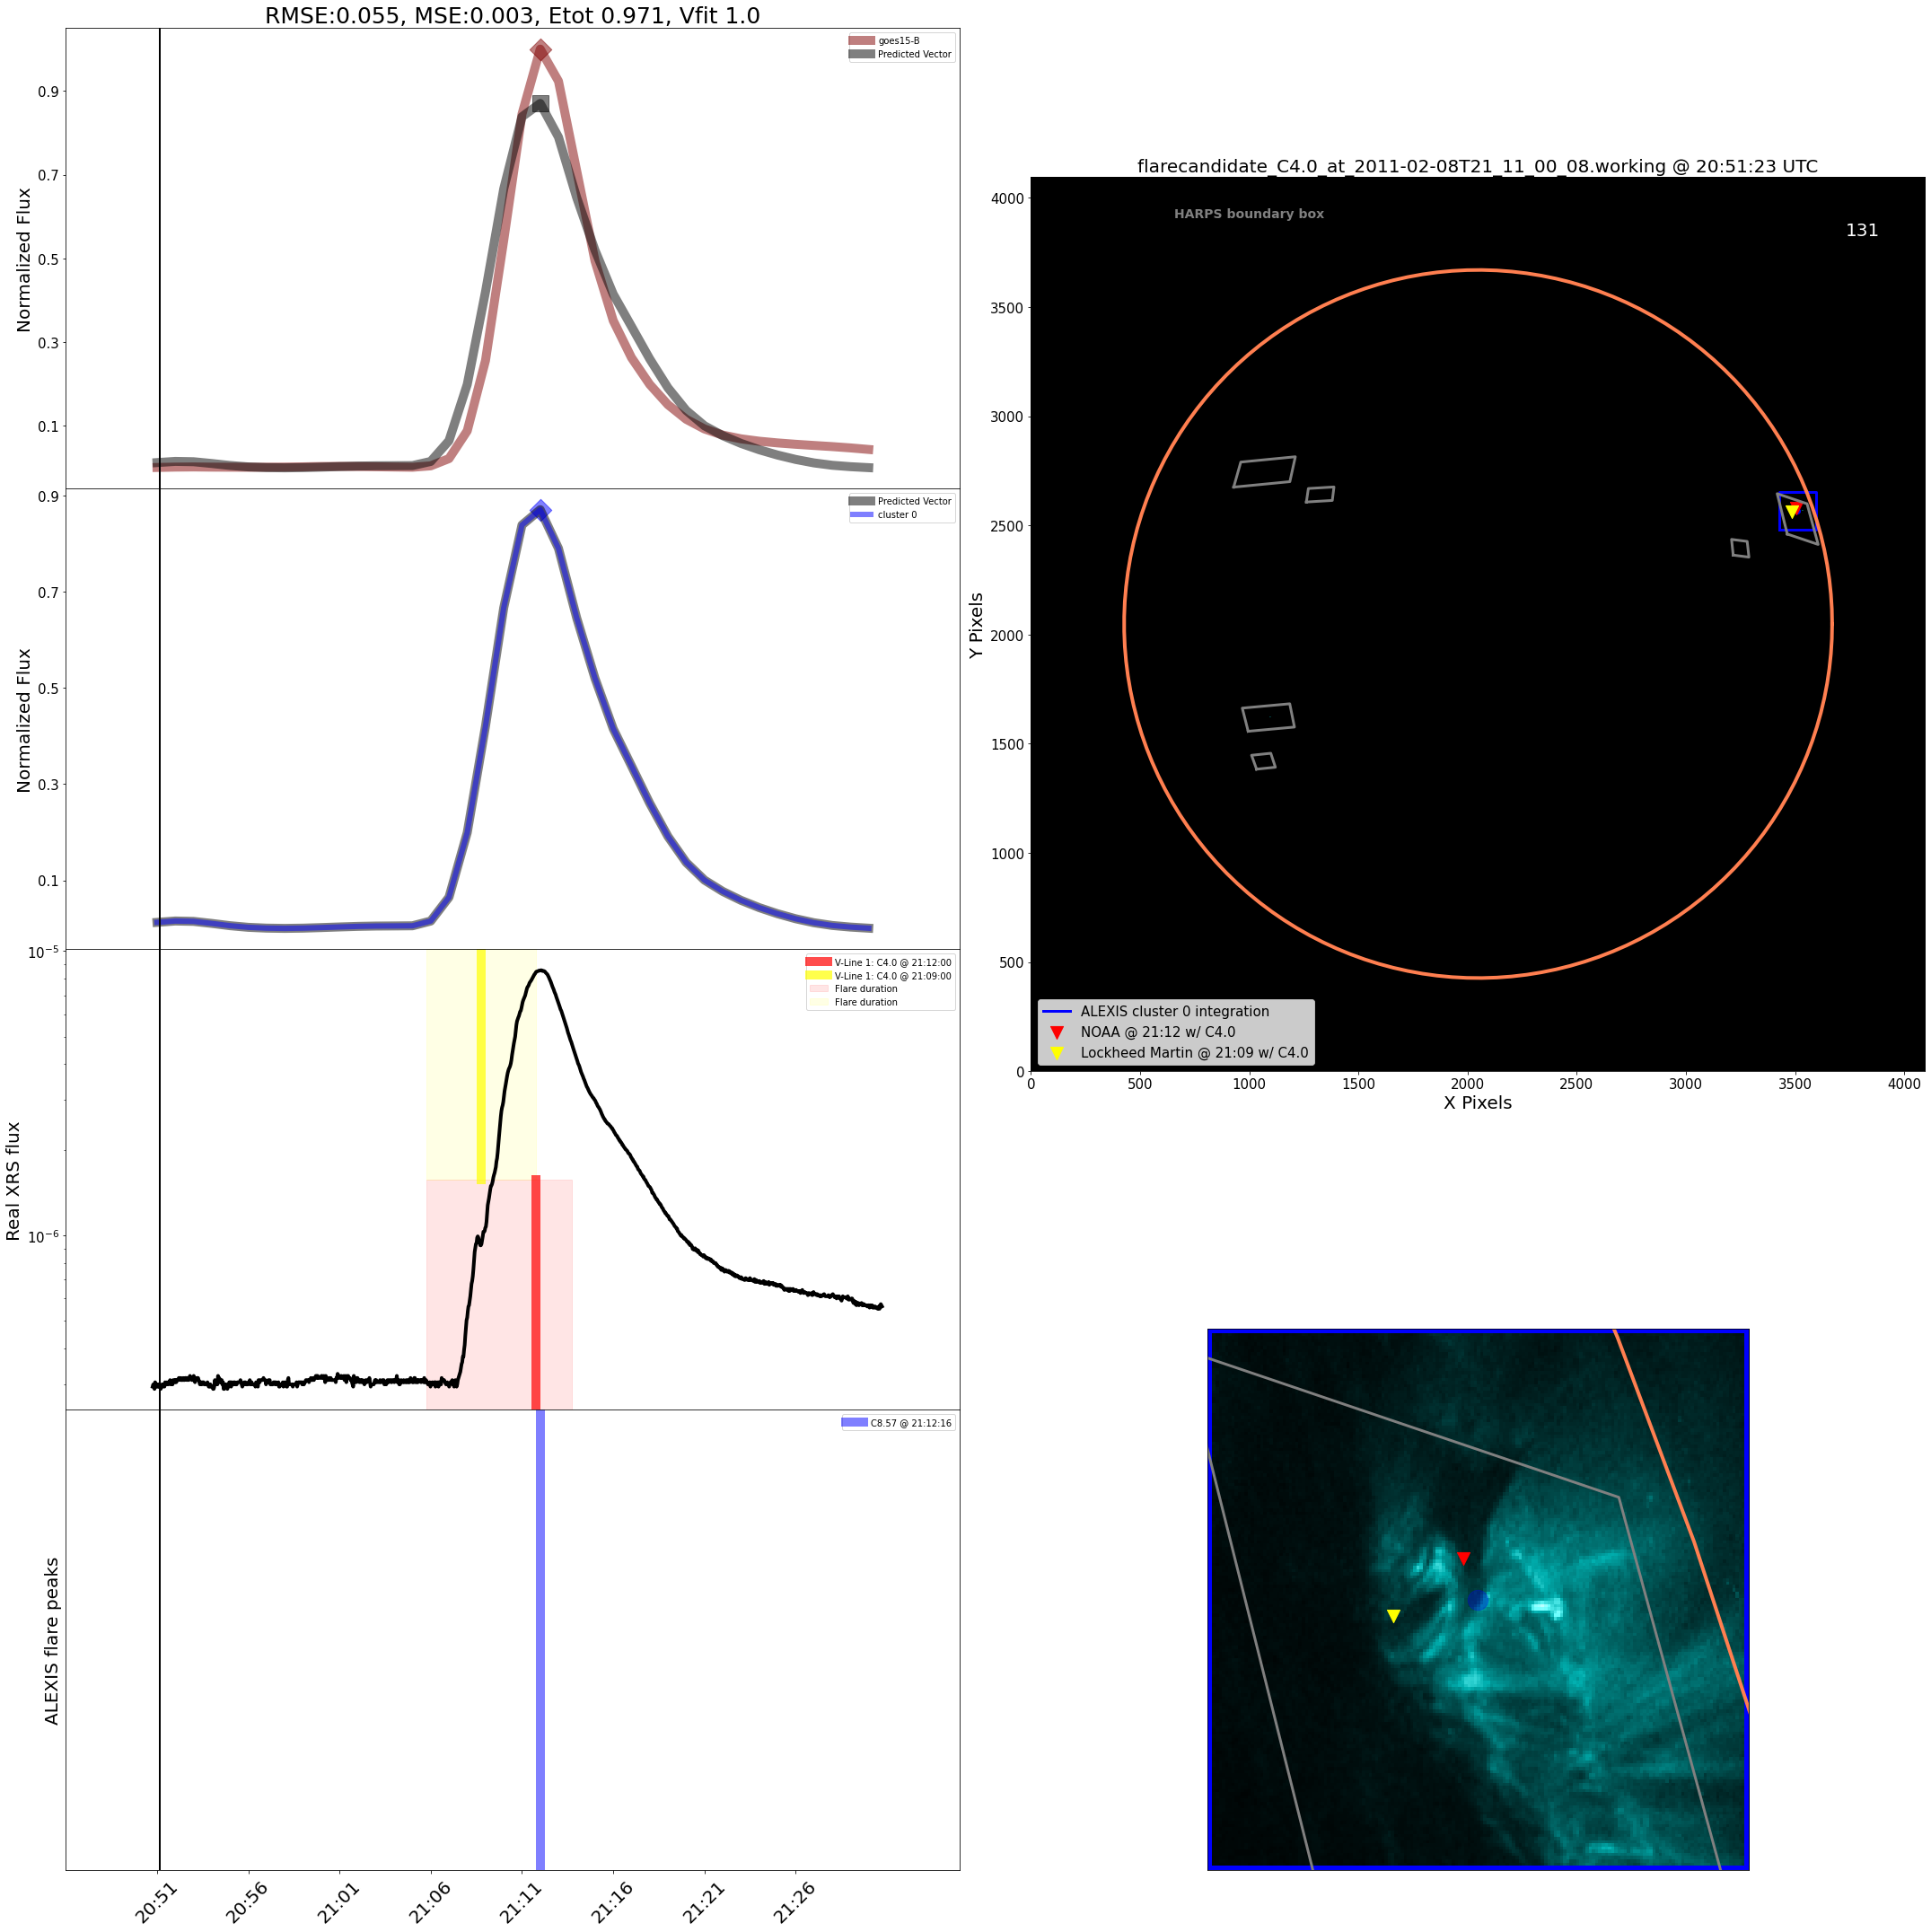

In [12]:
infile_list = glob(f'{dataconfig.DATA_DIR_FLARE_CANDIDATES}/*.working/defined_flares_w_harp_meta_and_goes_flare_class.pickle')
len(infiles)

for infile in infile_list:
    
#     outfile_file = 

    # outfile_name = f'{dataconfig.DATA_DIR_PRODUCTS}/alexis_paper_report_examples/{paper_plot_dict[infile_dict_key]}'
#     print(outfile_name)
    random_num = 1

    infile = helio_reg_exp_module.work_dir_from_flare_candidate_input_string(infile)

    print(infile)
    
    glob_file = glob(f'{dataconfig.DATA_DIR_FLARE_CANDIDATES}/{infile}/defined_flares_w_harp_meta_and_goes_flare_class*.v3_initialize_summary_jpegs_for_movie.pickle')

    print(len(glob_file))
# #     print(glob_file[3])
    file = glob_file[random_num]
    
    input_dict = pickle.load(open(file, 'rb'))

    image_df = pd.DataFrame([input_dict])

    xrs_df = pickle.load(open(image_df.iloc[0].real_xrs_data_path, 'rb'))

    flares_df = pickle.load(open(image_df.iloc[0].catalog_file, 'rb'))

    plot_results_for_movie(image_df, flares_df, xrs_df)
    
    plt.tight_layout()
    
    # plt.savefig(outfile_name, dpi = 300)

In [13]:
start_flare_list = glob(f'{dataconfig.DATA_DIR_FLARE_CANDIDATES}/*/first_hek_report.pickle')
start_flare_list

['/mnt/e/ALEXIS_data/flare_candidates/flarecandidate_C4.0_at_2011-02-08T21_11_00_08.working/first_hek_report.pickle']

In [14]:
pickle.load(open(start_flare_list[0], 'rb'))

,event_date,peak_time,goes_class,AR_num,hpc_x,hpc_y,hpc_bbox_poly,id_team,search_instrument,HARPNUM,final_cluster_label,working_dir
0,2011-02-08,2011-02-08 21:12:00+00:00,C4.0,11153.0,874.758000,318.837000,"[[874.284, 311.7294], [879.786, 309.9726], [87...",SWPC,GOES,[362],NaN,/mnt/e/ALEXIS_data/flare_candidates/flarecandi...
1,2011-02-08,2011-02-08 21:09:00+00:00,C4.0,1153.0,861.546000,308.074800,"[[17.04258, 127.524], [17.04258, 127.524], [17...",SolarSoft,AIA,[362],NaN,/mnt/e/ALEXIS_data/flare_candidates/flarecandi...
0,2011-02-08,2011-02-08 21:12:16.525000192+00:00,C8.57,[11153],877.471077,311.173261,"[[826.4710768447218, 260.1732609777037], [826....",ALEXIS,SDO-131-goes15-B,[362],0.0,/mnt/e/ALEXIS_data/flare_candidates/flarecandi...


In [15]:
# # movie_init_file = glob('/data/padialjr/jorge-helio/flare_candidates//ALEXIS_flares_w_harp_goes_class_and_known_flare_meta.movie_making_*.v3_initialize_summary_jpegs_for_movie.pickle')
# movie_init_file = glob('/data/padialjr/jorge-helio/flare_candidates/*/ALEXIS_flares_w_harp_goes_class_and_known_flare_meta.movie_making_*.v3_initialize_summary_jpegs_for_movie.pickle')


# def find_wd(this_file):
    
#     return(helio_reg_exp_module.work_dir_from_flare_candidate_input_string(this_file))

# wd_list = pd.DataFrame([{'wd': find_wd(this_file)} for this_file in movie_init_file]).wd.unique()



In [16]:
# # 19, 14, 137, 149, 186, 205,279, 281, 385

# paper_plot_dict = {'flarecandidate_C8.2_at_2012-07-01T15_45_00_47.working':'summary_plot_explain.jpg', 
#                    'flarecandidate_C9.6_at_2011-09-23T21_42_10_37.working':'start_stop_wrong.jpg', 
#                    'flarecandidate_C2.3_at_2013-05-01T18_52_30_32.working':'flare_duration_ex_2.jpg', 
#                    'flarecandidate_C7.0_at_2011-12-14T19_45_40_67.working':'hidden_signals.jpg', 
#                    'flarecandidate_C3.4_at_2014-01-05T18_17_20_29.working':'hidden_signals_2.jpg',
#                    'flarecandidate_M2.8_at_2011-09-24T18_13_30_37.working':'euv_to_def_mag.jpg',
#                    'flarecandidate_C2.7_at_2014-11-23T18_08_40_36.working':'euv_to_def_mag_2.jpg',
#                    'flarecandidate_C1.9_at_2011-09-15T03_08_20_37.working':'background_ex.jpg',
#                    'flarecandidate_C2.3_at_2015-10-27T15_49_40_55.working':'background_ex_2.jpg',
#                    'flarecandidate_C1.8_at_2013-04-28T15_44_00_10.working':'same_ar_2_flares.jpg',
#                    'flarecandidate_C2.8_at_2014-10-20T02_01_40_10.working':'same_ar_2_flares_2.jpg',
#                    'flarecandidate_C1.9_at_2014-07-06T20_52_40_60.working':'symp_ex.jpg', 
#                    'flarecandidate_C1.2_at_2014-03-20T16_06_00_21.working':'sym_ex_2.jpg',
#                    'flarecandidate_C1.9_at_2014-02-06T08_01_16_19.working':'symp_ex_3.jpg',
#                    'flarecandidate_C1.1_at_2011-11-29T01_16_00_16.working':'3_regions.jpg'}

# for infile_dict_key in paper_plot_dict:
    
# #     outfile_file = 

#     outfile_name = f'{dataconfig.DATA_DIR_PRODUCTS}/alexis_paper_report_examples/{paper_plot_dict[infile_dict_key]}'
# #     print(outfile_name)
#     random_num = 1

#     infile = infile_dict_key
    
#     glob_file = glob(f'/data/padialjr/jorge-helio/flare_candidates/{infile}/ALEXIS_flares_w_harp_goes_class_and_known_flare_meta.movie_making_*.v3_initialize_summary_jpegs_for_movie.pickle')
# #     print(glob_file[3])
#     file = glob_file[random_num]
    
#     input_dict = pickle.load(open(file, 'rb'))

#     image_df = pd.DataFrame([input_dict])

#     xrs_df = pickle.load(open(image_df.iloc[0].real_xrs_data_path, 'rb'))

#     flares_df = pickle.load(open(image_df.iloc[0].catalog_file, 'rb'))

#     plot_results_for_movie(image_df, flares_df, xrs_df)
    
#     plt.tight_layout()
    
#     plt.savefig(outfile_name, dpi = 300)